## LIB

In [1]:
# === LIB ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

# ---------------- Heston risk–neutral senza lambda ----------------
def heston_charfunc(phi, S0, v0, kappaQ, thetaQ, xi, rho, tau, r):
    a = kappaQ * thetaQ
    b = kappaQ                      # niente lambda in Q
    rspi = rho * xi * phi * 1j
    d = np.sqrt((rspi - b)**2 + (phi*1j + phi**2) * xi**2)
    g = (b - rspi + d) / (b - rspi - d)

    exp1 = np.exp(r * phi * 1j * tau)
    term2 = S0**(phi*1j) * ((1 - g*np.exp(d*tau)) / (1 - g))**(-2*a/xi**2)
    exp2 = np.exp(a*tau*(b - rspi + d)/xi**2 + v0*(b - rspi + d)*((1 - np.exp(d*tau))/(1 - g*np.exp(d*tau)))/xi**2)
    return exp1 * term2 * exp2

def _integrand(phi, S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r):
    args = (S0, v0, kappaQ, thetaQ, xi, rho, tau, r)
    num = np.exp(r*tau)*heston_charfunc(phi-1j, *args) - K*heston_charfunc(phi, *args)
    den = 1j*phi*K**(1j*phi)
    return num/den  # complesso

def heston_price_rec(S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r, umax=100.0, N=10000):
    args = (S0, v0, kappaQ, thetaQ, xi, rho, tau, r)
    P = 0.0
    dphi = umax / N
    for i in range(1, N):
        phi = dphi * (2*i + 1) / 2
        num = np.exp(r*tau)*heston_charfunc(phi-1j, *args) - K*heston_charfunc(phi, *args)
        den = 1j*phi*K**(1j*phi)
        P += dphi * num/den
    return float(np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi))

def heston_price(S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r):
    real_val, err = quad(lambda u: np.real(_integrand(u, S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r)),
                         0.0, 100.0, limit=200)
    return float((S0 - K*np.exp(-r*tau))/2 + real_val/np.pi)

# --- test rapido ---
if __name__ == "__main__":
    S0, K = 100.0, 100.0
    v0, r = 0.1, 0.03
    kappaQ, thetaQ, xi, rho = 1.5768, 0.0398, 0.3, -0.5711
    tau = 1.0
    price = heston_price(S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r)
    print("[TEST HESTON Q, no lambda] price =", price)


[TEST HESTON Q, no lambda] price = 12.422227179891545


## RATE

In [2]:
# === RATE ===
yield_maturities = np.array([1/12, 1.5/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yields = np.array([4.18, 4.15, 4.08, 4.00, 3.95, 3.79, 3.56, 3.46, 3.47, 3.59, 3.78, 4.02, 4.58, 4.60]).astype(float) / 100
curve_fit, status = calibrate_nss_ols(yield_maturities, yields)
curve_fit


NelsonSiegelSvenssonCurve(beta0=np.float64(0.04898343382138078), beta1=np.float64(-0.007002110250220919), beta2=np.float64(-0.04091844716803696), beta3=np.float64(0.0036452471208201294), tau1=np.float64(2.0), tau2=np.float64(5.0))

## IB

In [3]:
# === PARTE A: FETCH IB (con timestamp robusti e close di ieri) ===
import json, math, random, re, time
from typing import Iterable, List, Tuple, Optional
import numpy as np, pandas as pd
from ib_insync import IB, Stock, Option, util, BarData

TICKER = "MSTR"
USE_ALL_FUTURE_EXPIRIES = True
DATES_IT = []
OUT_PREFIX = "mstr_panel"
RISK_FREE = 0.035
DIV_YIELD = 0.0
NY_TZ = "America/New_York"

# ---------------- UTILS ----------------
def _to_ny(ts):
    t = pd.Timestamp(ts)
    return t.tz_localize(NY_TZ) if t.tzinfo is None else t.tz_convert(NY_TZ)

def yearfrac_365(start_ts, end_ts) -> float:
    s, e = _to_ny(start_ts), _to_ny(end_ts)
    return (e - s).total_seconds() / (365.0 * 24 * 3600.0)

_IT_MONTH = {"gen":1,"feb":2,"mar":3,"apr":4,"mag":5,"giu":6,"lug":7,"ago":8,"set":9,"ott":10,"nov":11,"dic":12}
def parse_user_expiries_it(user_expiries_it: Iterable[str]) -> List[pd.Timestamp]:
    out=[]
    for s in user_expiries_it:
        s=s.strip().lower().replace("’","'").replace("  "," ")
        m=re.match(r"(\d{1,2})\s+([a-z]{3})\s+(\d{2,4})", s)
        if not m: continue
        d, mon, y = int(m.group(1)), _IT_MONTH[m.group(2)], int(m.group(3))
        if y < 100: y += 2000
        ts=_to_ny(pd.Timestamp(year=y,month=mon,day=d))+pd.Timedelta(hours=16)
        out.append(ts)
    return sorted(set(out))

SUPPRESS_IB_CODES = {10089,10090,10091,10167,2104}
def setup_marketdata_mode(ib: IB):
    # prova realtime, poi delayed, poi frozen
    def _quiet(reqId, code, msg, contract):
        if code in SUPPRESS_IB_CODES: return
        print(f"IB Error {code}, reqId {reqId}: {msg}")
    try: ib.errorEvent.clear()
    except Exception: pass
    ib.errorEvent += _quiet
    for mkt_type in (1, 3, 4):
        try:
            ib.reqMarketDataType(mkt_type)
            break
        except Exception:
            continue

def connect_ib(host="127.0.0.1", port=7497, client_id=None) -> IB:
    util.startLoop()
    ib=IB()
    ids = ([client_id]+[i for i in range(2,199) if i!=client_id]) if client_id is not None else list(range(2,199))
    random.shuffle(ids)
    last=None
    for cid in ids:
        try:
            ib.connect(host,port,clientId=cid,readonly=True,timeout=10)
            if not ib.isConnected():
                raise TimeoutError("API connection failed")
            setup_marketdata_mode(ib)
            return ib
        except Exception as e:
            last=e
            try: ib.disconnect()
            except: pass
    raise RuntimeError(f"Connessione IB fallita. Ultimo errore: {last}")

# ---------------- EXPIRIES ----------------
def list_future_expiries(ib: IB, ticker: str, max_years: float = 5.0) -> List[pd.Timestamp]:
    stk = ib.qualifyContracts(Stock(ticker, "SMART", "USD"))[0]
    params = ib.reqSecDefOptParams(stk.symbol, "", stk.secType, stk.conId)
    expirations_raw = set()
    for p in params:
        if getattr(p, "expirations", None):
            expirations_raw.update(p.expirations)
    if not expirations_raw:
        raise RuntimeError("Nessuna expiration ricevuta da IB.")

    def _parse_exp(s: str) -> Optional[pd.Timestamp]:
        s = str(s).strip()
        clean = re.sub(r"[^0-9\-]", "", s)
        if re.fullmatch(r"\d{8}", clean):
            dt = pd.to_datetime(clean, format="%Y%m%d", errors="coerce")
        else:
            dt = pd.to_datetime(clean, errors="coerce")
        if pd.isna(dt): return None
        return _to_ny(dt) + pd.Timedelta(hours=16)

    today_ny = _to_ny(pd.Timestamp.now("UTC")).normalize()
    cutoff = today_ny + pd.Timedelta(days=int(max_years*365))
    out = [ts for s in expirations_raw if (ts := _parse_exp(s)) and today_ny <= ts <= cutoff]
    out = sorted(set(out))
    if not out:
        raise RuntimeError("Nessuna scadenza futura disponibile dopo il filtro.")
    return out

# ---------------- SPOT & PRICES ----------------
def _finite_pos(x) -> bool:
    try:
        return math.isfinite(x) and float(x) > 0
    except Exception:
        return False

def _pick_px_from_ticker(tk) -> Optional[float]:
    if _finite_pos(getattr(tk, "last", float("nan"))):   return float(tk.last)
    if _finite_pos(getattr(tk, "close", float("nan"))):  return float(tk.close)
    b = getattr(tk, "bid", float("nan")); a = getattr(tk, "ask", float("nan"))
    if _finite_pos(b) and _finite_pos(a): return 0.5*(float(b)+float(a))
    if _finite_pos(b):                    return float(b)
    if _finite_pos(a):                    return float(a)
    try:
        mp = tk.marketPrice()
        if _finite_pos(mp):              return float(mp)
    except Exception:
        pass
    return None

def _hist_latest_bar(ib: IB, stk: Stock, days=7, bar="5 mins", what="TRADES", useRTH=False):
    try:
        bars: List[BarData] = ib.reqHistoricalData(
            stk, endDateTime="", durationStr=f"{days} D",
            barSizeSetting=bar, whatToShow=what,
            useRTH=useRTH, formatDate=1, keepUpToDate=False
        )
        if bars:
            last = bars[-1]
            return float(last.close), pd.Timestamp(last.date, tz="UTC")
    except Exception:
        pass
    return None, None

def _yesterday_close(ib: IB, stk: Stock):
    bars = ib.reqHistoricalData(
        stk, endDateTime="", durationStr="6 D",
        barSizeSetting="1 day", whatToShow="TRADES",
        useRTH=True, formatDate=1, keepUpToDate=False
    )
    if not bars or len(bars) < 1:
        raise RuntimeError("Daily history insufficiente.")
    last = bars[-1]              # ultimo giorno di negoziazione RTH disponibile
    return float(last.close), pd.Timestamp(last.date, tz="UTC")

def fetch_spot_ref(ib: IB, ticker="MSTR") -> Tuple[float, pd.Timestamp, str, float, pd.Timestamp]:
    """
    Restituisce:
      S0, spot_ts_utc, source ('live'|'historical'|'historical_daily'), y_close, y_close_ts_utc
    """
    stk = ib.qualifyContracts(Stock(ticker,"SMART","USD"))[0]

    # 1) tentativo live snapshot
    for wait in (2.5, 3.5):
        try:
            tk = ib.reqMktData(stk,"",snapshot=True,regulatorySnapshot=False)
            ib.sleep(wait)
            px = _pick_px_from_ticker(tk)
            if px is not None:
                ypx, yts = _yesterday_close(ib, stk)
                return float(px), pd.Timestamp.now("UTC"), "live", ypx, yts
        except Exception:
            pass

    # 2) fallback storico più recente
    candidates=[]
    for what in ("TRADES","MIDPOINT","BID","ASK"):
        for useRTH in (False, True):
            px, ts = _hist_latest_bar(ib, stk, days=7, bar="5 mins", what=what, useRTH=useRTH)
            if px is not None and ts is not None:
                candidates.append((ts, px))
    if candidates:
        ts, px = max(candidates, key=lambda t: t[0])
        ypx, yts = _yesterday_close(ib, stk)
        return float(px), ts, "historical", ypx, yts

    # 3) daily RTH come ultima risorsa
    ypx, yts = _yesterday_close(ib, stk)
    return float(ypx), yts, "historical_daily", ypx, yts

# --- estrai timestamp trade da generic tick 375 (RTVolume) ---
def _extract_last_ts_from_rtvolume(tk) -> Optional[pd.Timestamp]:
    try:
        s = tk.rtVolume  # formato: "lastSize;lastTime;totalVolume;vwap;singleTrade;..."
        if not s: return None
        parts = str(s).split(";")
        if len(parts) >= 2:
            ms = int(parts[1])
            return pd.Timestamp(ms, unit="ms", tz="UTC")
    except Exception:
        pass
    return None

# ---------------- FETCH CHAIN ----------------
def _option_px_from_ticker(tk):
    vals=[]
    try:
        mg=tk.modelGreeks
        if mg and _finite_pos(getattr(mg,"optPrice", float("nan"))): vals.append(float(mg.optPrice))
    except Exception:
        pass
    b=getattr(tk,"bid",float("nan")); a=getattr(tk,"ask",float("nan"))
    if _finite_pos(b) and _finite_pos(a): vals.append(0.5*(b+a))
    if _finite_pos(getattr(tk,"last",float("nan"))):  vals.append(float(tk.last))
    if _finite_pos(getattr(tk,"close",float("nan"))): vals.append(float(tk.close))
    if _finite_pos(b): vals.append(float(b))
    if _finite_pos(a): vals.append(float(a))
    return float(vals[0]) if vals else float("nan")

def fetch_chain_fixed_strikes(
    ib: IB,
    ticker: str,
    expiries_ts: List[pd.Timestamp],
    strikes = tuple(np.arange(100.0, 900.0+1e-9, 10.0)),
    include_calls=True,
    include_puts=True,
    sleep_seconds=4.8,
    passes_per_expiry=2,
    batch_size=18,
    generic_ticks="106,375"  # 106=Option Computation, 375=RTVolume per timestamp
) -> pd.DataFrame:
    stk = ib.qualifyContracts(Stock(ticker, "SMART", "USD"))[0]
    S0, spot_ts, source, y_close, y_close_ts = fetch_spot_ref(ib, ticker)
    today_ny = _to_ny(pd.Timestamp.now("UTC")).normalize()

    rights=[]
    if include_calls: rights.append("C")
    if include_puts:  rights.append("P")

    rows=[]; report=[]
    for exp_ts in expiries_ts:
        T = yearfrac_365(today_ny, exp_ts)
        if T <= 0:
            report.append((exp_ts.strftime("%Y-%m-%d"), 0, "T<=0")); continue

        expiry_ymd = exp_ts.strftime("%Y%m%d")
        contracts = [
            Option(symbol=stk.symbol,
                   lastTradeDateOrContractMonth=expiry_ymd,
                   strike=float(k),
                   right=r,
                   exchange="SMART",
                   currency="USD",
                   tradingClass=stk.symbol)
            for r in rights for k in strikes
        ]

        qualified = ib.qualifyContracts(*contracts)
        got_before_total = len(rows)

        for _ in range(passes_per_expiry):
            for i in range(0, len(qualified), batch_size):
                qs = qualified[i:i+batch_size]
                tks = [ib.reqMktData(c, generic_ticks, snapshot=False, regulatorySnapshot=False) for c in qs]
                ib.sleep(sleep_seconds)
                for c, tk in zip(qs, tks):
                    px = _option_px_from_ticker(tk)
                    ts_tick = _extract_last_ts_from_rtvolume(tk)  # timestamp trade più recente
                    if math.isfinite(px) and px>0:
                        rows.append(dict(
                            right=c.right,
                            K=float(c.strike),
                            expiry_iso=str((_to_ny(pd.Timestamp(c.lastTradeDateOrContractMonth))+pd.Timedelta(hours=16)).isoformat()),
                            T=T,
                            close=float(px),
                            conId=c.conId,
                            symbol=c.localSymbol,
                            last_trade_ts_utc=str(ts_tick) if ts_tick is not None else None
                        ))
                for tk in tks:
                    try: ib.cancelMktData(tk)
                    except Exception: pass
                time.sleep(0.25)

        found = len(rows) - got_before_total
        report.append((exp_ts.strftime("%Y-%m-%d"), found, f"requested={len(qualified)}"))

    if not rows:
        raise RuntimeError("Nessuna quotazione valida.")

    df = (pd.DataFrame(rows)
            .drop_duplicates(subset=["conId"])
            .sort_values(["expiry_iso","right","K"])
            .reset_index(drop=True))
    df.attrs["S0"]=S0
    df.attrs["spot_ts"]=spot_ts
    df.attrs["source"]=source
    df.attrs["y_close"]=y_close
    df.attrs["y_close_ts"]=y_close_ts
    return df

# ---------------- PIPELINE ----------------
def run_pipeline(ticker=TICKER, dates_it=DATES_IT, out_prefix=OUT_PREFIX, sleep_seconds=4.8):
    ib=connect_ib()
    try:
        if USE_ALL_FUTURE_EXPIRIES:
            exps = list_future_expiries(ib, ticker)
        else:
            exps = parse_user_expiries_it(dates_it)
        if not exps:
            raise RuntimeError("Lista scadenze vuota/non valida.")

        df=fetch_chain_fixed_strikes(
            ib, ticker, exps,
            strikes=tuple(np.arange(100.0, 900.0+1e-9, 10.0)),
            include_calls=True, include_puts=True,
            sleep_seconds=sleep_seconds,
            passes_per_expiry=2
        )

        as_of_ny = str(_to_ny(pd.Timestamp.now("UTC")).normalize().date())

        meta={
            "ticker": ticker,
            "S0": float(df.attrs["S0"]),
            "spot_ts": str(df.attrs["spot_ts"]),            # timestamp effettivo dello spot usato
            "as_of_ny": as_of_ny,                           # data di riferimento NY
            "source": df.attrs["source"],                   # live/historical/historical_daily
            "y_close": float(df.attrs["y_close"]),          # close RTH ultimo giorno
            "y_close_ts": str(df.attrs["y_close_ts"]),
            "r": RISK_FREE,
            "q": DIV_YIELD
        }

        df.to_csv(f"{out_prefix}_chain.csv", index=False)
        with open(f"{out_prefix}_meta.json", "w") as f:
            json.dump(meta, f, indent=2)

        print(f"[FETCH] n={len(df)}  S0={meta['S0']:.4f}  -> {out_prefix}_chain.csv / _meta.json")
        print(f"[INFO] Spot source={meta['source']}  spot_ts(UTC)={meta['spot_ts']}  y_close={meta['y_close']:.4f}")
        print("[NOTE] Ogni riga opzione ha 'last_trade_ts_utc' se il timestamp del trade è disponibile.")
    finally:
        try: ib.disconnect()
        except Exception: pass

if __name__ == "__main__":
    run_pipeline()


Error 200, reqId 9: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=100.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 11: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=120.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 10: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=110.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 13: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=140.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 9: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 11: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 10: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 12: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=130.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 13: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 12: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 67: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=680.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 66: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=670.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 70: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=710.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 69: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=700.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 68: Nessuna descrizione di titoli trovata per la richiesta, con

IB Error 200, reqId 67: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 66: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 70: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 69: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 68: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 72: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 71: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 73: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 75: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 74: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 76: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 78: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 77: Nessuna descrizione di titol

Error 200, reqId 90: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=100.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 91: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=110.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 92: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=120.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 94: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=140.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 93: Nessuna descrizione di titoli trovata per la richiesta, con

IB Error 200, reqId 90: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 91: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 92: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 94: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 93: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 147: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 147: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 148: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 149: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 150: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 151: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 154: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 148: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 149: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 150: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 151: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 154: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 152: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 155: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 157: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 156: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 153: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 160: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 158: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=780.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 159: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=790.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 163: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=830.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 164: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=840.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 161: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 158: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 159: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 163: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 164: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 161: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 162: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 166: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 165: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 169: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 168: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=880.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 167: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 170: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=900.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=100.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=110.0, right='C', exchange='SMART', currency='USD', tradin

IB Error 200, reqId 168: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 167: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 170: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=812379278, symbol='MSTR', lastTradeDateOrContractMonth='20251024', strike=150.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  251024C00150000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 12, 55, 57, 206681, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=134.95, bidGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.03000000000003), askGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.03000000000003), lastGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.03000000000003), modelGreeks=OptionComputation(tickAttrib=0, impli

IB Error 200, reqId 379: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 380: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 381: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 382: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=130.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 383: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=140.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 382: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 383: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 439: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=700.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 436: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=670.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 437: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=680.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 438: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=690.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 441: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 439: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 436: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 437: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 438: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 441: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 440: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 442: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 443: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 444: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 446: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 445: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 447: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 448: Nessuna descriz

Error 200, reqId 459: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=900.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 458: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=890.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 456: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=870.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 460: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=100.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 461: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 457: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 459: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 458: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 456: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 460: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 461: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 464: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 462: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 463: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 517: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 518: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 519: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 517: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 518: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 519: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 520: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 523: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 525: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=750.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 521: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 522: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 520: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 523: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 525: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 521: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 522: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 526: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 528: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 524: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 527: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 529: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 530: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 532: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=820.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 535: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=850.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 536: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=860.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 533: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=830.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 534: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 531: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 532: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 535: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 536: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 533: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 534: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 538: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 537: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 539: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 540: Nessuna descrizione di titoli trovata per la richiesta


Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=720.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251031', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='M

IB Error 200, reqId 751: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 750: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 753: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 752: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 805: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=660.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 806: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=670.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 807: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=680.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 808: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=690.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 809: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 805: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 806: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 807: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 808: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 809: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 810: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 811: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 814: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 813: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 812: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 815: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 816: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 819: Nessuna descriz

Error 200, reqId 831: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=110.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 832: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=120.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 834: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=140.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 833: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=130.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 831: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 832: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 834: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 833: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 886: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=660.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 887: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 886: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 887: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 888: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 889: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 888: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 889: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 890: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 893: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 891: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 892: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=720.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 895: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 890: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 893: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 891: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 892: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 895: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 896: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 897: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 894: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 898: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 900: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 899: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 901: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 904: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=840.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 902: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=820.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 906: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=860.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 903: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=830.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 907: Nessuna descrizione di titoli trovata per la richiesta

IB Error 200, reqId 905: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 904: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 902: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 906: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 903: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 907: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 908: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 909: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 910: Nessuna descrizione di titoli trovata per la richiesta


Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=790.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=800.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=810.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=820.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=830.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251107', strike=840.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='M

IB Error 200, reqId 1119: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1122: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1123: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1120: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1121: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1175: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=660.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1176: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=670.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1178: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=690.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1179: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=700.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1177: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1175: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1176: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1178: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1179: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1177: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1180: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1181: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1182: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1183: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1185: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1184: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1188: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1187: Ne

Error 200, reqId 1192: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=830.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1194: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=850.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1197: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=880.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1196: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=870.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1195: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1193: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1192: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1194: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1197: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1196: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1195: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1198: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1199: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1201: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1200: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1203: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1202: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1204: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=140.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1204: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1256: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=660.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1257: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1258: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1256: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1257: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1258: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1259: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1262: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=720.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1260: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1261: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1264: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1259: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1262: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1260: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1261: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1264: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1267: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1265: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1263: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1266: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1268: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1269: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1270: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1272: Ne

Error 200, reqId 1273: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=830.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1274: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=840.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1275: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=850.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1277: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1276: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1271: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1273: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1274: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1275: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1277: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1276: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1278: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1280: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=900.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=100.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=110.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=120.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=130.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=140.0, right='C', exchange='SMART', 

IB Error 200, reqId 1279: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1280: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=819925649, symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=150.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  251114C00150000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 12, 59, 12, 463007, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=136.14, bboExchange='c70003', snapshotPermissions=3)
cancelMktData: No reqId found for contract Ticker(contract=Option(conId=819925734, symbol='MSTR', lastTradeDateOrContractMonth='20251114', strike=160.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  251114C00160000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 12, 59, 12, 629813, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=126.41, bboExchange='c70003', snapshotPermissions=3)
cancelMktDat

IB Error 200, reqId 1528: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1530: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1532: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=570.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1534: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=590.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1532: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1534: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1536: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=610.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1538: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=630.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1542: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=670.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1540: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=650.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1544: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1536: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1538: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1542: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1540: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1544: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1543: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1545: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1547: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1546: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1550: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1548: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1549: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1552: Ne

Error 200, reqId 1553: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=780.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1556: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=810.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1557: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=820.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1560: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=850.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1559: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1555: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1553: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1556: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1557: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1560: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1559: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1558: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1561: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1562: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1563: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1564: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1565: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1609: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=530.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1611: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=550.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1613: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=570.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1615: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=590.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1609: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1611: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1613: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1617: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=610.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1619: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=630.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1615: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1617: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1621: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=650.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1619: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1621: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1623: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1624: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1623: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1624: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1625: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1626: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1627: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1632: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=760.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1629: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1625: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1626: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1627: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1632: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1629: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1628: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1630: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1631: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1633: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1634: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1636: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1635: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1637: Ne

Error 200, reqId 1638: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=820.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1642: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=860.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1641: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=850.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1643: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1644: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1640: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1638: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1642: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1641: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1643: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1644: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1646: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=900.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=530.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=550.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=570.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=590.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=610.0, right='C', exchange='SMART', 

IB Error 200, reqId 1645: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1646: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=824906277, symbol='MSTR', lastTradeDateOrContractMonth='20251121', strike=100.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  251121C00100000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 13, 0, 20, 101552, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=185.67, bidGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.72), askGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.72), lastGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.72), modelGreeks=OptionComputation(tickAttrib=0, impliedVol=1.5984043115182367, delta=0.994

IB Error 200, reqId 1847: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1849: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1848: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1851: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1850: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1904: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=670.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1903: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=660.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1906: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=690.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1905: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=680.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1908: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1904: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1903: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1906: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1905: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1908: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1907: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1909: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1910: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1911: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1914: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1913: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1912: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1915: Ne

Error 200, reqId 1925: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=880.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1926: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=890.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1927: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=900.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1928: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=100.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1929: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1925: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1926: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1927: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1928: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1929: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1930: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1931: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1932: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1984: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=660.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1985: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1984: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1985: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1986: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1987: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 1986: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1987: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 1988: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1989: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1990: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=720.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1991: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 1992: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 1988: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1989: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1990: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1991: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1992: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1994: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1993: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1995: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1996: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1997: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1998: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2000: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2002: Ne

Error 200, reqId 1999: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=810.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2004: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=860.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2001: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=830.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2006: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=880.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2005: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 2003: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 1999: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2004: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2001: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2006: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2005: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2007: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2008: Nessuna descrizione di titoli trovata per la richiesta


Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=850.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=860.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=880.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=890.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251128', strike=900.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
cancelMktData: No reqId found for 

IB Error 200, reqId 2213: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2215: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2217: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2214: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2216: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 2261: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=580.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2262: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=590.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 2261: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2262: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 2263: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=600.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2264: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=610.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2265: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=620.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 2263: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2264: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 2266: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=630.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2267: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=640.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2269: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=660.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2268: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=650.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2270: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 2265: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2266: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2267: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2269: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2268: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2270: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2272: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2274: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2271: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2273: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2275: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2277: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2278: Ne

Error 200, reqId 2284: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=810.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2283: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=800.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2285: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=820.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2286: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=830.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2289: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 2284: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2283: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2285: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2286: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2289: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2288: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2290: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2287: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2291: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2294: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2293: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2292: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2295: Ne

Error 200, reqId 2342: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=580.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2343: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=590.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2344: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=600.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 2342: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2343: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2344: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 2345: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=610.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2346: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=620.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2347: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=630.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2348: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=640.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2349: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 2345: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2346: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2347: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2348: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 2350: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=660.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2351: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 2349: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2350: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2351: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 2352: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2353: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2356: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=720.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2355: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2354: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 2352: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2353: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2356: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2355: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2354: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2358: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 2357: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2360: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=760.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2359: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=750.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2363: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=790.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2362: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 2361: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2357: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2360: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2359: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2363: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2362: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2364: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2365: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2367: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2366: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2369: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2370: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2368: Ne

Error 200, reqId 2371: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2372: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=880.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2373: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=890.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 2374: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=900.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20

IB Error 200, reqId 2371: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2372: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2373: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 2374: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=825931587, symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=150.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  251205C00150000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 13, 2, 28, 395135, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=136.01, bboExchange='c70003', snapshotPermissions=3)
cancelMktData: No reqId found for contract Ticker(contract=Option(conId=825931682, symbol='MSTR', lastTradeDateOrContractMonth='20251205', strike=160.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  251205C00160000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 13, 2, 28, 519102, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=126.29, bboExchange='c70003', snapshotPermissions=3)
cancelMktData:

IB Error 200, reqId 4491: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4492: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4493: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4494: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4495: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4532: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=510.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4534: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=530.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 4532: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4534: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4543: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=620.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4544: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=630.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4542: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=610.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4546: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=650.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4545: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 4543: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4544: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4542: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4546: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4545: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4547: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4549: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4548: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4550: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4552: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4551: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4554: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4553: Ne

Error 200, reqId 4569: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=880.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4568: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=870.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4567: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=860.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4570: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=890.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4571: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 4569: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4568: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4567: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4570: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4571: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4573: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4572: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4575: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4574: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4576: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4613: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=510.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4615: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=530.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 4613: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4615: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4623: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=610.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4624: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=620.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4625: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=630.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4626: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=640.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 4623: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4624: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4625: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4627: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=650.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4628: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=660.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 4626: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4627: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4628: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4629: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4630: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4633: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4631: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 4629: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4630: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4633: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4632: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4635: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4636: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=740.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4637: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=750.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4634: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 4631: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4632: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4635: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4636: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4637: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4634: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4638: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4639: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4640: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4641: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4643: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4645: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4642: Ne

Error 200, reqId 4648: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=860.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4650: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=880.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4649: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4651: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=890.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4652: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 4648: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4650: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4649: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4651: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4652: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=825214578, symbol='MSTR', lastTradeDateOrContractMonth='20260417', strike=150.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  260417C00150000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 13, 9, 47, 208330, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=147.14, bidGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=293.05), askGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=293.05), lastGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=293.05), modelGreeks=OptionComputation(tickAttrib=0, impliedVol=0.8690411785573738, delta=0.919

IB Error 200, reqId 4829: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4830: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4831: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4832: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4833: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=140.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 4833: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4885: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=660.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4886: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=670.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4887: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=680.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4888: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=690.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4890: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 4885: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4886: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4887: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4888: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4890: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4889: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4892: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4891: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4893: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4895: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4894: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4897: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4896: Ne

Error 200, reqId 4909: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=900.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4911: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=110.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4912: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=120.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4910: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=100.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4913: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 4909: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4911: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4912: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4910: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4913: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4914: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4966: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=660.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4967: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4968: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 4966: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4967: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4968: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4969: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4970: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4972: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=720.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4973: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4971: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 4969: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4970: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4972: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4973: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4971: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4974: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4976: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4975: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4977: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4979: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4978: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4981: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=810.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4983: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=830.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4982: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=820.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4985: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=850.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 4984: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 4980: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4981: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4983: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4982: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4985: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4984: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4986: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4987: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4988: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 4990: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=900.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=100.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=110.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=120.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=130.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=140.0, right='C', exchange='SMART', 

IB Error 200, reqId 4989: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 4990: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=825214838, symbol='MSTR', lastTradeDateOrContractMonth='20260515', strike=150.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  260515C00150000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 13, 10, 44, 483319, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=148.87, bidGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=293.13), askGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=293.13), lastGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=293.13), modelGreeks=OptionComputation(tickAttrib=0, impliedVol=0.8517530240832505, delta=0.91

IB Error 200, reqId 6240: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 6238: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 6242: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 6244: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 6246: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 6321: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=830.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 6319: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=810.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 6323: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=850.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 6325: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 6321: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 6319: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 6323: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 6325: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 6327: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=890.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=810.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=830.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=850.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=870.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=890.0, right='C', exchange='SMART', 

IB Error 200, reqId 6327: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=747873537, symbol='MSTR', lastTradeDateOrContractMonth='20261218', strike=100.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  261218C00100000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 13, 14, 57, 973082, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=200.14, bidGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.77), askGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.77), lastGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.77), modelGreeks=OptionComputation(tickAttrib=0, impliedVol=0.8838444491194489, delta=0.94

IB Error 200, reqId 7196: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7197: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7198: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7199: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7277: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270617', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7279: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270617', strike=890.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7278: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270617', strike=880.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7280: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270617', strike=900.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20

IB Error 200, reqId 7277: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7279: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7278: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7280: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=757330528, symbol='MSTR', lastTradeDateOrContractMonth='20270617', strike=100.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  270617C00100000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 13, 18, 11, 433951, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=206.06, bidGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.85), askGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.85), lastGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.85), modelGreeks=OptionComputation(tickAttrib=0, impliedVol=0.8305414745197407, delta=0.94

IB Error 200, reqId 7589: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7593: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7591: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7590: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7592: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7630: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=510.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7632: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=530.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7634: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=550.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 7630: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7632: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7634: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7636: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=570.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7638: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=590.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 7636: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7640: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=610.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7642: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=630.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7644: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=650.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7647: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=680.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7646: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 7638: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7640: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7642: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7644: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7647: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7646: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7648: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7649: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7650: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7651: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7652: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7653: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7654: Ne

Error 200, reqId 7661: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=820.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7660: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=810.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7663: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=840.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7670: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=100.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7673: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 7662: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7661: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7660: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7663: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7670: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7673: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7672: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=120.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7674: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=140.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7671: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=110.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 7672: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7674: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7671: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7711: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=510.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7713: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=530.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7715: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=550.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7717: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=570.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7719: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 7711: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7713: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7715: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7717: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7721: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=610.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7723: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=630.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 7719: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7721: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7723: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7725: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=650.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 7725: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7727: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=670.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7728: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=680.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 7727: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7728: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 7729: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=690.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7733: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7730: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=700.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7735: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=750.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 7732: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 7729: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7733: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7730: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7735: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7732: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7731: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7737: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7734: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7736: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7738: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7740: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7739: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 7741: Ne

Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=100.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=110.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=120.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=130.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=140.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20270917', strike=510.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='M

IB Error 200, reqId 8500: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8498: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8499: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8501: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8502: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8506: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8503: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8504: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8505: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8507: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8510: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8508: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8509: Ne

Error 200, reqId 8516: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=890.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 8517: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=900.0, right='C', exchange='SMART', currency='USD', tradingClass='MSTR')


IB Error 200, reqId 8516: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8517: Nessuna descrizione di titoli trovata per la richiesta


Error 200, reqId 8581: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=730.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 8579: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=710.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 8580: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=720.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 8582: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=740.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 8583: Nessuna descrizione di titoli trovata per la rich

IB Error 200, reqId 8581: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8579: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8580: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8582: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8583: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8584: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8586: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8585: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8588: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8587: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8589: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8590: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8592: Ne

Error 200, reqId 8595: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=870.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 8597: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=890.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 8596: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=880.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Error 200, reqId 8598: Nessuna descrizione di titoli trovata per la richiesta, contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=900.0, right='P', exchange='SMART', currency='USD', tradingClass='MSTR')
Unknown contract: Option(symbol='MSTR', lastTradeDateOrContractMonth='20

IB Error 200, reqId 8595: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8597: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8596: Nessuna descrizione di titoli trovata per la richiesta
IB Error 200, reqId 8598: Nessuna descrizione di titoli trovata per la richiesta


cancelMktData: No reqId found for contract Ticker(contract=Option(conId=816241314, symbol='MSTR', lastTradeDateOrContractMonth='20280121', strike=100.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='MSTR  280121C00100000', tradingClass='MSTR'), time=datetime.datetime(2025, 10, 24, 13, 22, 27, 651948, tzinfo=datetime.timezone.utc), minTick=0.01, bid=-1.0, bidSize=0.0, ask=-1.0, askSize=0.0, volume=0.0, close=212.1, bidGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.47), askGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.47), lastGreeks=OptionComputation(tickAttrib=0, impliedVol=None, delta=None, optPrice=None, pvDividend=0.0, gamma=None, vega=-2.0, theta=-2.0, undPrice=292.47), modelGreeks=OptionComputation(tickAttrib=0, impliedVol=0.8024599030864444, delta=0.939

[FETCH] n=2684  S0=292.0300  -> mstr_panel_chain.csv / _meta.json
[INFO] Spot source=live  spot_ts(UTC)=2025-10-24 12:55:51.480405+00:00  y_close=284.9200
[NOTE] Ogni riga opzione ha 'last_trade_ts_utc' se il timestamp del trade è disponibile.


## PULIZIA E NODI

In [4]:
# === PARTE A.2: CLEANING & NODI ===
import json, numpy as np, pandas as pd
from math import exp

try:
    OUT_PREFIX
except NameError:
    OUT_PREFIX = "mstr_panel"

T_AVAILABLE = np.array([
    0.021,0.040,0.059,0.098,0.194,0.270,0.347,0.443,
    0.520,0.596,1.018,1.268,1.344,1.763,2.016,2.25
], float)

M_CORE = np.array([0.90,1.00,1.10,1.25], float)
M_WING = np.array([1.50,1.75,2.00], float)

def _first_existing(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def _yearfrac_365(start_ts, end_ts):
    s = pd.to_datetime(start_ts, utc=True, errors="coerce")
    e = pd.to_datetime(end_ts,   utc=True, errors="coerce")
    return (e - s).total_seconds() / (365.0*24*3600.0)

def _ensure_T(df, meta):
    tcol = _first_existing(df, ["T","tau","ttm","time_to_maturity","maturity_years","T_years"])
    if tcol:
        df = df.rename(columns={tcol:"T"}).copy()
        df["T"] = pd.to_numeric(df["T"], errors="coerce")
        return df.loc[np.isfinite(df["T"])].copy()
    dcol = _first_existing(df, ["days_to_expiry","daysToExpiry","DTE","dte"])
    if dcol:
        df = df.copy()
        df["T"] = pd.to_numeric(df[dcol], errors="coerce")/365.0
        return df.loc[np.isfinite(df["T"])].copy()
    exp_col = _first_existing(df, ["expiry_iso","expiry","expiration","expiryISO","lastTradeDateOrContractMonth","expiryYmd"])
    if exp_col is None:
        raise KeyError("Impossibile derivare T: nessuna colonna T/DTE/expiry trovata.")
    exp = df[exp_col].astype(str)
    mask_ymd  = exp.str.fullmatch(r"\d{8}")
    exp2 = exp.copy()
    exp2.loc[mask_ymd] = exp.loc[mask_ymd] + " 16:00"
    mask_date = exp2.str.fullmatch(r"\d{4}-\d{2}-\d{2}")
    exp2.loc[mask_date] = exp2.loc[mask_date] + " 16:00"
    spot_ts = meta.get("spot_ts", pd.Timestamp.now("UTC").isoformat())
    df = df.copy()
    df["T"] = exp2.apply(lambda x: _yearfrac_365(spot_ts, x))
    df["T"] = pd.to_numeric(df["T"], errors="coerce")
    return df.loc[np.isfinite(df["T"])].copy()

def clean_chain_for_calibration(
    chain_csv=f"{OUT_PREFIX}_chain.csv",
    meta_json=f"{OUT_PREFIX}_meta.json",
    out_csv=f"{OUT_PREFIX}_calls_clean.csv",
    out_report=f"{OUT_PREFIX}_clean_report.json",
    out_nodes_csv=f"{OUT_PREFIX}_calib_nodes.csv",
    use_calls=True,
    K_range=(100.0,800.0),
    T_range=(1/365,5.0),
    price_floor=1e-3,
    price_cap_mult=1.05,
    min_strikes_per_expiry=10,
    drop_dupes=True,
    enforce_monotonic_K=True,
    T_tolerance=0.05
):
    df = pd.read_csv(chain_csv)
    meta = json.load(open(meta_json))

    K_col      = _first_existing(df, ["K","strike","Strike","STRIKE"])
    price_col  = _first_existing(df, ["close","price","last","settle","optPrice","C","call_price","call_mid"])
    right_col  = _first_existing(df, ["right","cp","optionRight"])
    expiry_col = _first_existing(df, ["expiry_iso","expiry","expiration","expiryISO","lastTradeDateOrContractMonth","expiryYmd"])

    if K_col is None or price_col is None:
        raise KeyError("Mancano colonne essenziali: K o prezzo (es. close/price).")

    df = df.rename(columns={K_col:"K", price_col:"close"}).copy()
    if right_col:  df = df.rename(columns={right_col:"right"})
    if expiry_col: df = df.rename(columns={expiry_col:"expiry_iso"})

    df["K"] = pd.to_numeric(df["K"], errors="coerce")
    df["close"] = pd.to_numeric(df["close"], errors="coerce")

    df = _ensure_T(df, meta)
    if "T" not in df.columns:
        raise KeyError("Colonna T assente dopo _ensure_T.")

    if use_calls and "right" in df.columns:
        df = df[df["right"]=="C"].copy()

    df = df[np.isfinite(df["close"]) & (df["close"]>price_floor)]
    df = df[np.isfinite(df["K"])]
    df = df[(df["K"]>=K_range[0]) & (df["K"]<=K_range[1])]
    df = df[(df["T"]>=T_range[0]) & (df["T"]<=T_range[1])]

    S0 = float(meta.get("S0", np.nan))
    if np.isfinite(S0):
        df.loc[:, "close"] = df["close"].clip(lower=0.0, upper=price_cap_mult*S0)

    if drop_dupes and "conId" in df.columns:
        df = df.drop_duplicates(subset=["conId"]).copy()

    grp_key = "expiry_iso" if "expiry_iso" in df.columns else "T"
    cnt = df.groupby(grp_key)["K"].nunique()
    good = set(cnt[cnt>=min_strikes_per_expiry].index)
    df = df[df[grp_key].isin(good)].copy()

    sort_keys = ["expiry_iso","T","K"] if "expiry_iso" in df.columns else ["T","K"]
    df = df.sort_values(sort_keys).reset_index(drop=True)

    if enforce_monotonic_K and len(df):
        def _mono_fix(g):
            g = g.copy()
            g["close"] = np.minimum.accumulate(g["close"].to_numpy(float))
            return g
        gkeys = ["expiry_iso","T"] if "expiry_iso" in df.columns else ["T"]
        df = (df.groupby(gkeys, as_index=False, sort=False)
                .apply(_mono_fix)
                .reset_index(drop=True))

    df.to_csv(out_csv, index=False)

    if "T" not in df.columns:
        df = _ensure_T(df, meta)

    r=float(meta.get("r",0.0)); q=float(meta.get("q",0.0))
    Ts_present = np.sort(df["T"].unique())
    T_map = []
    for Tav in T_AVAILABLE:
        if Ts_present.size == 0:
            break
        j = int(np.argmin(np.abs(Ts_present - Tav)))
        Tmatch = float(Ts_present[j])
        if abs(Tmatch - Tav) <= T_tolerance and (Tmatch, Tav) not in T_map:
            T_map.append((Tmatch, Tav))

    rows = []
    for Tmatch, Tav in T_map:
        F = (S0 if np.isfinite(S0) else float(df["K"].median())) * exp((r-q)*Tmatch)
        mset = M_CORE if Tmatch < 1.0 else np.concatenate([M_CORE, M_WING])
        K_targets = np.clip(mset*F, K_range[0], K_range[1])

        dft = df[np.isclose(df["T"].values, Tmatch, rtol=0, atol=1e-6)].sort_values("K").copy()
        if dft.empty:
            continue
        Ks = dft["K"].to_numpy(float)

        chosen = set(); picks = []
        for Kt in K_targets:
            j = int(np.argmin(np.abs(Ks - Kt)))
            idx = dft.index[j]; bump=1
            while idx in chosen and (j-bump>=0 or j+bump<Ks.size):
                cand=[]
                if j-bump>=0:   cand.append((abs(Ks[j-bump]-Kt), dft.index[j-bump]))
                if j+bump<Ks.size: cand.append((abs(Ks[j+bump]-Kt), dft.index[j+bump]))
                if not cand: break
                idx = sorted(cand, key=lambda x: x[0])[0][1]
                bump+=1
            if idx not in chosen:
                chosen.add(idx); picks.append(idx)
        if picks:
            sel = dft.loc[sorted(picks)].copy()
            sel["T_req"] = Tav
            rows.append(sel)

    nodes = pd.concat(rows, axis=0).sort_values(["T","K"]).reset_index(drop=True) if rows else df.iloc[0:0].copy()
    nodes.to_csv(out_nodes_csv, index=False)

    report = {
        "S0": float(S0) if np.isfinite(S0) else None,
        "n_rows": int(len(df)),
        "n_expiries": int(df[grp_key].nunique()) if len(df) else 0,
        "K_min": float(df["K"].min()) if len(df) else None,
        "K_max": float(df["K"].max()) if len(df) else None,
        "T_min": float(df["T"].min()) if len(df) else None,
        "T_max": float(df["T"].max()) if len(df) else None,
        "expiries_kept_at_least": int(min_strikes_per_expiry),
        "calib_nodes": int(len(nodes)),
        "calib_Ts": int(nodes["T"].nunique()) if len(nodes) else 0
    }
    with open(out_report, "w") as f:
        json.dump(report, f, indent=2)

    print(f"[CLEAN] rows={report['n_rows']} expiries={report['n_expiries']} "
          f"K∈[{report['K_min']:.1f},{report['K_max']:.1f}] T∈[{report['T_min']:.3f},{report['T_max']:.3f}]")
    print(f"[NODES] selezionati {report['calib_nodes']} punti su {report['calib_Ts']} scadenze (tolleranza T=±{T_tolerance}y)")
    print(f"-> {out_csv}  /  {out_nodes_csv}  /  {out_report}")

    return df, report, nodes

if __name__ == "__main__":
    clean_chain_for_calibration()


[CLEAN] rows=948 expiries=20 K∈[250.0,800.0] T∈[0.021,2.246]
[NODES] selezionati 54 punti su 10 scadenze (tolleranza T=±0.05y)
-> mstr_panel_calls_clean.csv  /  mstr_panel_calib_nodes.csv  /  mstr_panel_clean_report.json


C:\Users\salvm\AppData\Local\Temp\ipykernel_15024\3986876726.py:123: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_mono_fix)


## FILTERING

In [5]:
# === FILTERING 1 ===
import json, numpy as np, pandas as pd

OUT_PREFIX = "mstr_panel"
df = pd.read_csv(f"{OUT_PREFIX}_chain.csv")
meta = json.load(open(f"{OUT_PREFIX}_meta.json"))
S0 = float(meta["S0"])

if "right" in df.columns:
    df = df[df["right"] == "C"].copy()

assert "T" in df.columns, "Manca la colonna T nel chain.csv"

pivot = (df.pivot_table(index="T", columns="K", values="close", aggfunc="mean")
           .sort_index().sort_index(axis=1))

T_min, T_max = 0.04, 3.00
K_min, K_max = 100.0, 900.0

volSurface = pivot.loc[(pivot.index >= T_min) & (pivot.index <= T_max),
                       (pivot.columns >= K_min) & (pivot.columns <= K_max)].copy()

while volSurface.isna().values.any() and not volSurface.empty:
    rows_with_nan = volSurface.index[volSurface.isna().any(axis=1)]
    cols_with_nan = volSurface.columns[volSurface.isna().any(axis=0)]
    volSurface.drop(index=rows_with_nan, columns=cols_with_nan, inplace=True, errors="ignore")

if volSurface.empty:
    raise ValueError("Tutto rimosso: nessun retticolo completo senza NaN con i filtri correnti.")

price_arr = volSurface.to_numpy()
maturities = volSurface.index.to_list()
common_strikes = volSurface.columns.to_list()

print("Number of common strikes:", len(common_strikes))
print("Shape:", price_arr.shape)
volSurface


Number of common strikes: 29
Shape: (8, 29)


K              250.0       260.0       270.0       280.0       290.0  \
T                                                                      
0.155365   51.506607   44.812476   38.536417   33.087124   28.230826   
0.232078   57.207624   50.969583   45.069285   39.769446   34.968316   
0.327968   63.730466   57.760608   52.185714   47.069713   42.476235   
0.404566   68.661192   62.903048   57.376832   52.372693   47.939360   
0.651142   81.165269   76.098034   71.114947   66.246054   62.058916   
0.903196   91.313367   86.271948   81.624430   76.949151   72.783818   
1.229338  102.322529   97.446321   93.171275   89.027134   85.126108   
2.149886  127.127455  123.470389  119.662641  115.684433  112.055670   

K              300.0       310.0       320.0      330.0      340.0  ...  \
T                                                                   ...   
0.155365   23.781239   20.200754   17.024308  14.313997  12.169792  ...   
0.232078   30.615249   26.860482   23.418941  20.571493  17.965480  ...   
0.327968   38.172032   34.292511   30.842085  27.695213  25.020904  ...   
0.404566   43.589604   39.775098   36.215856  32.985290  30.173417  ...   
0.651142   57.798432   53.942934   50.415566  47.120615  44.054846  ...   
0.903196   68.866524   65.070456   61.676571  58.347188  55.323516  ...   
1.229338   81.215044   77.544851   74.400002  71.053813  68.074851  ...   
2.149886  108.757224  105.728973  102.183059  99.356122  96.558899  ...   

K             440.0      450.0      460.0      470.0      480.0      490.0  \
T                                                                            
0.155365   3.453173   3.192720   2.941949   2.703815   2.572600   2.444462   
0.232078   6.086106   5.626396   5.183031   4.818841   4.551588   4.302312   
0.327968   9.854221   9.212733   8.587141   7.977297   7.414243   7.035707   
0.404566  13.354844  12.508472  11.716856  10.957740  10.323271   9.820457   
0.651142  23.778637  22.453179  21.223572  20.218023  19.241467  18.346926   
0.903196  33.750000  32.202111  30.742649  29.628941  28.438795  27.261736   
1.229338  45.460745  43.548131  42.188121  40.736068  39.297538  37.871771   
2.149886  73.438253  71.296030  69.618553  68.029947  66.250593  64.884655   

K             500.0      520.0      540.0      560.0  
T                                                     
0.155365   2.320345   2.110000   1.920000   1.790649  
0.232078   4.063439   3.607979   3.293247   3.030601  
0.327968   6.650059   5.924178   5.352833   4.930954  
0.404566   9.276418   8.304102   7.611017   6.968175  
0.651142  17.361507  15.900873  14.612980  13.580000  
0.903196  26.017065  24.170000  22.420000  20.959921  
1.229338  36.491604  34.224638  32.092374  30.143155  
2.149886  63.130647  60.305492  57.806195  55.339671  

[8 rows x 29 columns]

In [6]:
# === FILTERING 2: nuova superficie filtrata (T>0.2, K ogni 3) ===
import numpy as np, pandas as pd, json

OUT_PREFIX = "mstr_panel"

def _ensure_volsurface_long_full():
    df = pd.read_csv(f"{OUT_PREFIX}_chain.csv")
    if "right" in df.columns:
        df = df[df["right"] == "C"].copy()

    colK  = "K" if "K" in df.columns else ("strike" if "strike" in df.columns else None)
    colPx = "close" if "close" in df.columns else ("price" if "price" in df.columns else None)
    if colK is None or colPx is None:
        raise KeyError("Mancano colonne strike/prezzo nel chain.csv")

    if "T" not in df.columns:
        meta = json.load(open(f"{OUT_PREFIX}_meta.json"))
        spot_ts = meta.get("spot_ts")
        if spot_ts is None:
            raise KeyError("Manca T e meta['spot_ts']")
        exp_col = None
        for c in ["expiry_iso","expiration","expiry","lastTradeDateOrContractMonth","expiryYmd"]:
            if c in df.columns:
                exp_col = c; break
        if exp_col is None:
            raise KeyError("Manca T e nessuna colonna expiry trovata")
        def _yearfrac_365(start_ts, end_ts):
            s = pd.to_datetime(start_ts, utc=True, errors="coerce")
            e = pd.to_datetime(end_ts,   utc=True, errors="coerce")
            return (e - s).total_seconds() / (365.0*24*3600.0)
        exp = df[exp_col].astype(str)
        mask_ymd = exp.str.fullmatch(r"\d{8}")
        exp2 = exp.copy()
        exp2.loc[mask_ymd] = exp.loc[mask_ymd] + " 16:00"
        mask_date = exp2.str.fullmatch(r"\d{4}-\d{2}-\d{2}")
        exp2.loc[mask_date] = exp2.loc[mask_date] + " 16:00"
        df = df.copy()
        df["T"] = exp2.apply(lambda x: _yearfrac_365(spot_ts, x))

    df = df.rename(columns={colK:"strike", colPx:"price"}).copy()

    long_full = (df[["T","strike","price"]]
                 .rename(columns={"T":"maturity"})
                 .dropna(subset=["maturity","strike","price"])
                 .astype({"maturity":float,"strike":float,"price":float})
                 .groupby(["maturity","strike"], as_index=False)["price"].mean())
    return long_full

if "volSurfaceLong_full" not in globals():
    volSurfaceLong_full = _ensure_volsurface_long_full()

def rate_fn(T: float) -> float:
    if "curve_fit" in globals():
        return float(curve_fit(float(T)))
    try:
        return float(RISK_FREE)
    except NameError:
        return 0.0

pivot_full = (volSurfaceLong_full
              .pivot_table(index="maturity", columns="strike", values="price", aggfunc="mean")
              .sort_index().sort_index(axis=1))

# ----- filtro griglia -----
T_cut = 0.30
K_min, K_max = 100.0, 900.0

rows_mask = pivot_full.index >= T_cut
all_K = pivot_full.columns.to_numpy(float)
mask_K = (all_K >= K_min) & (all_K <= K_max)
K_step = pd.Index(all_K[mask_K][::3], name=pivot_full.columns.name)

surf = pivot_full.loc[rows_mask, K_step.intersection(pivot_full.columns)].copy()

# rimozione iterativa NaN
while surf.isna().values.any() and not surf.empty:
    bad_rows = surf.index[surf.isna().any(axis=1)]
    bad_cols = surf.columns[surf.isna().any(axis=0)]
    surf.drop(index=bad_rows, columns=bad_cols, inplace=True, errors="ignore")

if surf.empty:
    raise ValueError("Nessun retticolo completo dopo il filtro T>0.2 e K ogni 3.")

volSurfaceFiltered = surf

# long + tassi
volSurfaceFilteredLong = volSurfaceFiltered.melt(ignore_index=False).reset_index()
volSurfaceFilteredLong.columns = ["maturity","strike","price"]
volSurfaceFilteredLong = volSurfaceFilteredLong.astype({"maturity":float,"strike":float,"price":float})
volSurfaceFilteredLong["rate"] = volSurfaceFilteredLong["maturity"].apply(rate_fn)

# report griglia
n_T, n_K = volSurfaceFiltered.shape
print(f"volSurfaceFiltered: {n_T} T × {n_K} K  -> punti = {n_T*n_K}")

# ----- export: chain_(numero-di-punti).csv -----
out = (volSurfaceFilteredLong
       .sort_values(["maturity","strike"], kind="mergesort")
       .reset_index(drop=True))

n_points = len(out)
# coerenza con la griglia
assert n_points == n_T * n_K, "Conteggio punti non coincide con n_T * n_K."

CHAIN_FILENAME = f"chain_data.csv"
out.to_csv(CHAIN_FILENAME, index=False)
print(f"Salvati {n_points} punti in {CHAIN_FILENAME}")


volSurfaceFiltered: 6 T × 11 K  -> punti = 66
Salvati 66 punti in chain_data.csv


## CALIBRAZIONE NO DEFAULT minmizza rmse

In [ ]:
# === CALIBRAZIONE HESTON (senza lambda) — chain_data + timing [FIX residui] ===
import numpy as np, pandas as pd, json, time, os, hashlib
from scipy.optimize import least_squares

OUT_PREFIX = "mstr_panel"
CHAIN_FILE = "chain_data.csv"

# --- util salvataggio robusto ---
def _save_json_atomic(path, obj):
    data = json.dumps(obj, indent=2)
    tmp = f"{path}.tmp"
    with open(tmp, "w", encoding="utf-8", newline="\n") as f:
        f.write(data)
    with open(tmp, "r", encoding="utf-8") as f:
        json.load(f)
    os.replace(tmp, path)

def _sha256(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for ch in iter(lambda: f.read(65536), b""):
            h.update(ch)
    return h.hexdigest()

# --- meta e dataset ---
meta = json.load(open(f"{OUT_PREFIX}_meta.json", "r", encoding="utf-8"))
S0 = float(meta["S0"])
vsl = pd.read_csv(CHAIN_FILE).dropna()
assert {"maturity","strike","price","rate"}.issubset(vsl.columns)
print(f"Calibrazione su {len(vsl)} punti da {CHAIN_FILE}")

K   = vsl["strike"].to_numpy(float)
tau = vsl["maturity"].to_numpy(float)
r   = vsl["rate"].to_numpy(float)
P   = vsl["price"].to_numpy(float)

# --- pricer veloce ---
def heston_price_rec_fast(S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r, umax=50.0, N=3000):
    args = (S0, v0, kappaQ, thetaQ, xi, rho, tau, r)
    acc = 0.0
    dphi = umax / N
    for i in range(1, N):
        phi = dphi * (2*i + 1) / 2
        num = np.exp(r*tau)*heston_charfunc(phi-1j, *args) - K*heston_charfunc(phi, *args)
        den = 1j*phi*K**(1j*phi)
        acc += dphi * num/den
    return float(np.real((S0 - K*np.exp(-r*tau))/2 + acc/np.pi))

def price_vector_fast(S0, v0, kappaQ, thetaQ, xi, rho, K, tau, r):
    out = np.empty_like(K, dtype=float)
    for i in range(K.size):
        px = heston_price_rec_fast(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                   float(tau[i]), float(r[i]))
        out[i] = px if (np.isfinite(px) and px >= 0) else 1e9
    return out

# --- residui: penalità Feller sempre presente ---
w = 1.0 / np.maximum(P, 1.0)
PEN_SCALE = 10.0

def residuals(x):
    v0, kappaQ, thetaQ, xi, rho = map(float, x)
    model = price_vector_fast(S0, v0, kappaQ, thetaQ, xi, rho, K, tau, r)
    core = w * (model - P)
    feller_violation = max(0.0, xi*xi - 2.0*kappaQ*thetaQ)
    pen = PEN_SCALE * feller_violation
    return np.concatenate([core, np.array([pen], dtype=float)])

# --- ottimizzazione ---
x0 = np.array([0.427768, 6.424547, 0.315257, 2.000000, -0.60])
lb = np.array([1e-6,  0.05, 1e-6, 0.10, -0.999])
ub = np.array([0.95, 10.00, 0.90, 2.00,  0.999])

t0 = time.perf_counter()
res = least_squares(residuals, x0, bounds=(lb, ub),
                    loss="soft_l1", f_scale=5.0,
                    max_nfev=20000, xtol=1e-6, ftol=1e-6, verbose=1)
elapsed_sec = time.perf_counter() - t0

print("success:", res.success, " cost:", res.cost, " seconds:", f"{elapsed_sec:.3f}")

v0, kappaQ, thetaQ, xi, rho = map(float, res.x)
print("v0=%.6f  kappaQ=%.6f  thetaQ=%.6f  xi=%.6f  rho=%.6f" % (v0, kappaQ, thetaQ, xi, rho))

# --- ricalcolo accurato su chain_data (usa heston_price_rec lento) ---
P_fit = np.array([heston_price_rec(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                   float(tau[i]), float(r[i]))
                  for i in range(K.size)], dtype=float)
mae  = float(np.mean(np.abs(P - P_fit)))
rmse = float(np.sqrt(np.mean((P - P_fit)**2)))
print("MAE:", mae, "  RMSE:", rmse)

# --- salvataggio robusto ---
params = {"v0": v0, "kappaQ": kappaQ, "thetaQ": thetaQ,
          "xi": xi, "rho": rho, "S0": float(S0),
          "opt_cost": float(res.cost), "opt_seconds": float(elapsed_sec)}
base_path = f"{OUT_PREFIX}_heston_params.json"
_save_json_atomic(base_path, params)
print(f"[SAVE] -> {base_path} size={os.path.getsize(base_path)} sha256={_sha256(base_path)[:12]}")


## calibrazione no default minmizza rmse relativo

In [10]:
# === CALIBRAZIONE HESTON — RMSE relativo con vincolo di Feller ===
import numpy as np, pandas as pd, json, time, os, hashlib
from scipy.optimize import least_squares

OUT_PREFIX = "mstr_panel"
CHAIN_FILE = "chain_data.csv"

# --- util salvataggio robusto ---
def _save_json_atomic(path, obj):
    data = json.dumps(obj, indent=2)
    tmp = f"{path}.tmp"
    with open(tmp, "w", encoding="utf-8", newline="\n") as f:
        f.write(data)
    with open(tmp, "r", encoding="utf-8") as f:
        json.load(f)
    os.replace(tmp, path)

def _sha256(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for ch in iter(lambda: f.read(65536), b""):
            h.update(ch)
    return h.hexdigest()

# --- meta e dataset ---
meta = json.load(open(f"{OUT_PREFIX}_meta.json", "r", encoding="utf-8"))
S0 = float(meta["S0"])
vsl = pd.read_csv(CHAIN_FILE).dropna()
assert {"maturity","strike","price","rate"}.issubset(vsl.columns)
print(f"Calibrazione su {len(vsl)} punti da {CHAIN_FILE}")

K   = vsl["strike"].to_numpy(float)
tau = vsl["maturity"].to_numpy(float)
r   = vsl["rate"].to_numpy(float)
P   = vsl["price"].to_numpy(float)

EPS = 1e-8
XI_MIN = 0.10    # soglia minima desiderata su xi
F_EPS  = 1e-12   # per stabilità in sqrt

# --- pricer veloce ---
def heston_price_rec_fast(S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r, umax=50.0, N=3000):
    args = (S0, v0, kappaQ, thetaQ, xi, rho, tau, r)
    acc = 0.0
    dphi = umax / N
    for i in range(1, N):
        phi = dphi * (2*i + 1) / 2
        num = np.exp(r*tau)*heston_charfunc(phi-1j, *args) - K*heston_charfunc(phi, *args)
        den = 1j*phi*K**(1j*phi)
        acc += dphi * num/den
    return float(np.real((S0 - K*np.exp(-r*tau))/2 + acc/np.pi))

def price_vector_fast(S0, v0, kappaQ, thetaQ, xi, rho, K, tau, r):
    out = np.empty_like(K, dtype=float)
    for i in range(K.size):
        px = heston_price_rec_fast(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                   float(tau[i]), float(r[i]))
        out[i] = px if (np.isfinite(px) and px >= 0) else 1e12
    return out

# --- riparametrizzazione per Feller: xi in [XI_MIN, sqrt(2 kappa theta)]
# variabili di ottimizzazione: y = [v0, kappaQ, thetaQ, u, rho] con u in [0,1]
def unpack_y(y):
    v0, kappaQ, thetaQ, u, rho = map(float, y)
    xi_cap = np.sqrt(np.maximum(2.0*kappaQ*thetaQ, F_EPS))
    # mappa xi = XI_MIN + u * max(0, xi_cap - XI_MIN)
    xi = XI_MIN + u * np.maximum(0.0, xi_cap - XI_MIN)
    return v0, kappaQ, thetaQ, xi, rho

# --- residui: errori relativi puri ---
def residuals_rel(y):
    v0, kappaQ, thetaQ, xi, rho = unpack_y(y)
    model = price_vector_fast(S0, v0, kappaQ, thetaQ, xi, rho, K, tau, r)
    rel = (model - P) / np.maximum(P, EPS)
    return rel

# --- bounds sulle variabili y ---
# v0, kappaQ, thetaQ come prima; u in [0,1]; rho in [-0.999,0.999]
lb = np.array([1e-6,  0.05, 1e-6, 0.0,  -0.999])
ub = np.array([0.95, 10.00, 0.90, 1.0,   0.999])

# --- iniziali ---
x0_abs = np.array([0.408380, 8.153344, 0.312601, 1.592876, 0.840747])  # [v0,kappa,theta,xi,rho] vecchio
# converti a y0 scegliendo u coerente con xi_min e xi_cap(x0)
xi_cap0 = np.sqrt(max(2.0*x0_abs[1]*x0_abs[2], F_EPS))
u0 = 0.8 if xi_cap0 <= XI_MIN else (min(max((x0_abs[3]-XI_MIN)/(xi_cap0-XI_MIN), 0.2), 0.95))
y0 = np.array([x0_abs[0], x0_abs[1], x0_abs[2], u0, x0_abs[4]])

# --- ottimizzazione ---
t0 = time.perf_counter()
res = least_squares(residuals_rel, y0, bounds=(lb, ub),
                    loss="linear",  # RMSE relativo puro
                    max_nfev=20000, xtol=1e-6, ftol=1e-6, verbose=1)
elapsed_sec = time.perf_counter() - t0

print("success:", res.success, " cost(=0.5*sum rel^2):", res.cost, " seconds:", f"{elapsed_sec:.3f}")

# --- parametri finali e diagnostica ---
v0, kappaQ, thetaQ, xi, rho = unpack_y(res.x)
print("v0=%.6f  kappaQ=%.6f  thetaQ=%.6f  xi=%.6f  rho=%.6f" % (v0, kappaQ, thetaQ, xi, rho))
print("Feller check: 2*kappa*theta=%.9f  xi^2=%.9f  margin=%.9f" %
      (2*kappaQ*thetaQ, xi*xi, 2*kappaQ*thetaQ - xi*xi))

# --- ricalcolo accurato e metriche ---
P_fit = np.array([heston_price_rec(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                   float(tau[i]), float(r[i]))
                  for i in range(K.size)], dtype=float)

abs_mae  = float(np.mean(np.abs(P - P_fit)))
abs_rmse = float(np.sqrt(np.mean((P - P_fit)**2)))

rel_err  = (P_fit - P) / np.maximum(P, EPS)
rel_mae  = float(np.mean(np.abs(rel_err)))
rel_rmse = float(np.sqrt(np.mean(rel_err**2)))

print("ABS  -> MAE:", abs_mae, " RMSE:", abs_rmse)
print("REL  -> MAE:", rel_mae,  " RMSE:", rel_rmse, " (in % ->)", rel_mae*100, rel_rmse*100)

# --- salvataggio ---
params = {"v0": v0, "kappaQ": kappaQ, "thetaQ": thetaQ,
          "xi": xi, "rho": rho, "S0": float(S0),
          "opt_cost": float(res.cost), "opt_seconds": float(elapsed_sec),
          "objective": "relative_RMSE", "feller_enforced": True, "xi_min": XI_MIN}
base_path = f"{OUT_PREFIX}_heston_params.json"
_save_json_atomic(base_path, params)
print(f"[SAVE] -> {base_path} size={os.path.getsize(base_path)} sha256={_sha256(base_path)[:12]}")


Calibrazione su 66 punti da chain_data.csv
`xtol` termination condition is satisfied.
Function evaluations 42, initial cost 5.2522e+00, final cost 8.2552e-02, first-order optimality 1.90e-03.
success: True  cost(=0.5*sum rel^2): 0.08255245953371002  seconds: 834.798
v0=0.399605  kappaQ=9.066376  thetaQ=0.311355  xi=1.677704  rho=0.902494
Feller check: 2*kappa*theta=5.645730174  xi^2=2.814690449  margin=2.831039725
ABS  -> MAE: 1.4989797178837587  RMSE: 1.974238324801536
REL  -> MAE: 0.039457177628294114  RMSE: 0.04841090501873636  (in % ->) 3.9457177628294113 4.841090501873635
[SAVE] -> mstr_panel_heston_params.json size=314 sha256=d2d2bbd54c58


## parametri scelti

import json

PARAMS_FILE = "mstr_panel_heston_params.json"

with open(PARAMS_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

data.update({
    "v0": 0.408380,
    "kappaQ": 8.153344,
    "thetaQ": 0.312601,
    "xi": 1.592876,
    "rho": 0.840747,
})

with open(PARAMS_FILE, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

## ANALISI DEI RESIDUI

In [11]:
# === RESIDUI (base) su chain_data.csv usando mstr_panel_heston_params.json ===
import numpy as np, pandas as pd, json, os

OUT_PREFIX = "mstr_panel"
PARAMS_FILE = f"{OUT_PREFIX}_heston_params.json"
CHAIN_FILE = "chain_data.csv"
EPS = 1e-8

assert os.path.exists(PARAMS_FILE), f"{PARAMS_FILE} non trovato"
with open(PARAMS_FILE, "r", encoding="utf-8") as f:
    p = json.load(f)

S0     = float(p["S0"])
v0     = float(p["v0"])
kappaQ = float(p["kappaQ"])
thetaQ = float(p["thetaQ"])
xi     = float(p["xi"])
rho    = float(p["rho"])

vsl = pd.read_csv(CHAIN_FILE).dropna()
assert {"maturity","strike","price","rate"}.issubset(vsl.columns)

K = vsl["strike"].to_numpy(float)
T = vsl["maturity"].to_numpy(float)
r = vsl["rate"].to_numpy(float)
P = vsl["price"].to_numpy(float)

def _price_vector_acc(S0, v0, kappaQ, thetaQ, xi, rho, K, T, r):
    out = np.empty_like(K, dtype=float)
    for i in range(K.size):
        out[i] = heston_price_rec(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                  float(T[i]), float(r[i]))
    return out

price_fn = price_vector_fast if "price_vector_fast" in globals() else _price_vector_acc
Ph = price_fn(S0, v0, kappaQ, thetaQ, xi, rho, K, T, r)

df = vsl.copy()
df["heston_price"] = Ph
df["rel_err"] = np.abs(df["price"] - df["heston_price"]) / np.maximum(df["price"], EPS)

g = df.groupby("maturity", sort=True)
err_inf = g["rel_err"].max()
counts  = g.size()

err_table = (pd.DataFrame({"rel_err_inf": err_inf, "n_points": counts})
             .reset_index()
             .sort_values("maturity")
             .reset_index(drop=True))
err_table["rel_err_inf_pct"] = 100.0 * err_table["rel_err_inf"]

print(err_table)

rel_mae  = float(df["rel_err"].mean())
rel_rmse = float(np.sqrt((df["rel_err"]**2).mean()))
print("Rel MAE:", rel_mae, " Rel RMSE:", rel_rmse," (in % ->)", rel_mae*100, rel_rmse*100)


   maturity  rel_err_inf  n_points  rel_err_inf_pct
0  0.327968     0.213685        11        21.368523
1  0.404566     0.135681        11        13.568134
2  0.651142     0.060380        11         6.037952
3  0.903196     0.050693        11         5.069324
4  1.229338     0.037106        11         3.710567
5  2.149886     0.075064        11         7.506400
Rel MAE: 0.03605697282247862  Rel RMSE: 0.05001589430210858  (in % ->) 3.605697282247862 5.001589430210858


## Grafico surface from csv

In [12]:
# === READ FROM CSV ===
import json, os, numpy as np, pandas as pd
import plotly.graph_objects as go

CHAIN_FILE = "chain_data.csv"              # creato dal tuo pipeline
PARAMS_FILE = "mstr_panel_heston_params.json"  # salvato in calibrazione

df = pd.read_csv(CHAIN_FILE).dropna()
assert {"maturity","strike","price","rate"} <= set(df.columns)

# === HESTON PRICE: usa file già salvato se esiste, altrimenti calcola con i parametri ===
if os.path.exists("chain_with_heston.csv"):
    df = pd.read_csv("chain_with_heston.csv").dropna(subset=["maturity","strike","price"])
    assert "heston_price" in df.columns
else:
    assert os.path.exists(PARAMS_FILE), f"{PARAMS_FILE} mancante"
    p = json.load(open(PARAMS_FILE,"r"))
    S0, v0, kappaQ, thetaQ, xi, rho = map(float, (p["S0"], p["v0"], p["kappaQ"], p["thetaQ"], p["xi"], p["rho"]))

    # pricer veloce coerente col tuo codice
    def heston_charfunc(phi, S0, v0, kappaQ, thetaQ, xi, rho, tau, r):
        a = kappaQ*thetaQ
        b = kappaQ
        rspi = rho*xi*phi*1j
        d = np.sqrt((rspi - b)**2 + (phi*1j + phi**2)*xi**2)
        g = (b - rspi + d)/(b - rspi - d)
        exp1 = np.exp(r*phi*1j*tau)
        term2 = S0**(phi*1j) * ((1 - g*np.exp(d*tau))/(1 - g))**(-2*a/xi**2)
        exp2 = np.exp(a*tau*(b - rspi + d)/xi**2 + v0*(b - rspi + d)*((1 - np.exp(d*tau))/(1 - g*np.exp(d*tau)))/xi**2)
        return exp1*term2*exp2

    def heston_price_rec_fast(S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r, umax=50.0, N=3000):
        args = (S0, v0, kappaQ, thetaQ, xi, rho, tau, r)
        acc = 0.0
        dphi = umax / N
        for i in range(1, N):
            phi = dphi*(2*i + 1)/2
            num = np.exp(r*tau)*heston_charfunc(phi-1j, *args) - K*heston_charfunc(phi, *args)
            den = 1j*phi*K**(1j*phi)
            acc += dphi * num/den
        return float(np.real((S0 - K*np.exp(-r*tau))/2 + acc/np.pi))

    Ks   = df["strike"].to_numpy(float)
    Taus = df["maturity"].to_numpy(float)
    Rs   = df["rate"].to_numpy(float)

    Ph = np.empty_like(Ks, dtype=float)
    for i in range(Ks.size):
        Ph[i] = heston_price_rec_fast(S0, float(Ks[i]), v0, kappaQ, thetaQ, xi, rho,
                                      float(Taus[i]), float(Rs[i]))
    df["heston_price"] = Ph
    df.to_csv("chain_with_heston.csv", index=False)

# === PLOT (da CSV) ===
# opzionale: filtri come in pipeline
T_cut = 0.30
K_min, K_max = 250.0, 900.0
plot_df = df[(df["maturity"]>=T_cut) & (df["strike"].between(K_min, K_max))].copy()

x = plot_df["maturity"].to_numpy(float)
y = plot_df["strike"].to_numpy(float)
z_mkt = plot_df["price"].to_numpy(float)
z_fit = plot_df["heston_price"].to_numpy(float)

fig = go.Figure()
fig.add_trace(go.Mesh3d(x=x, y=y, z=z_mkt, opacity=0.55, name="Market (mesh)"))
fig.add_trace(go.Scatter3d(x=x, y=y, z=z_fit, mode="markers", marker=dict(size=3), name="Heston (markers)"))
fig.update_layout(
    title_text="Market Prices (CSV) vs Calibrated Heston Prices",
    scene=dict(xaxis_title="TIME (Years)", yaxis_title="STRIKE", zaxis_title="CALL PRICE"),
    height=800, width=900, legend=dict(x=0.02, y=0.98)
)
fig.show()


## calibrazione default lamda fixed

In [13]:
# === CALIBRAZIONE HESTON CON DEFAULT COSTANTE (λ fisso) — RMSE relativo + Feller ===
# Richiede: heston_charfunc / heston_price_rec già definiti

import numpy as np, pandas as pd, json, time
from scipy.optimize import least_squares
from datetime import datetime

LAMBDA_DEFAULT = 0.035
OUT_PREFIX = "mstr_panel"
CHAIN_FILE = "chain_data.csv"

# --- S0 e dataset ---
meta = json.load(open(f"{OUT_PREFIX}_meta.json"))
S0 = float(meta["S0"])

vsl = pd.read_csv(CHAIN_FILE).dropna()
assert {"maturity","strike","price","rate"}.issubset(vsl.columns)
vsl = vsl.astype({"maturity":float,"strike":float,"price":float,"rate":float}).reset_index(drop=True)
vsl["rate_eff"] = vsl["rate"] + LAMBDA_DEFAULT
print(f"Calibrazione default su {len(vsl)} punti da {CHAIN_FILE} | λ={LAMBDA_DEFAULT}")

K     = vsl["strike"].to_numpy(float)
tau   = vsl["maturity"].to_numpy(float)
r_eff = vsl["rate_eff"].to_numpy(float)
P     = vsl["price"].to_numpy(float)

EPS = 1e-8
XI_MIN = 0.10     # lower bound desiderato su xi
F_EPS  = 1e-12    # stabilità numerica

# --- pricer veloce (usa r_eff) ---
def heston_price_rec_fast_default(S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r_eff, umax=50.0, N=3000):
    args = (S0, v0, kappaQ, thetaQ, xi, rho, tau, r_eff)
    acc = 0.0
    dphi = umax / N
    for i in range(1, N):
        phi = dphi * (2*i + 1) / 2
        num = np.exp(r_eff*tau)*heston_charfunc(phi-1j, *args) - K*heston_charfunc(phi, *args)
        den = 1j*phi*K**(1j*phi)
        acc += dphi * num/den
    return float(np.real((S0 - K*np.exp(-r_eff*tau))/2 + acc/np.pi))

def price_vector_fast_default(S0, v0, kappaQ, thetaQ, xi, rho, K, tau, r_eff):
    out = np.empty_like(K, dtype=float)
    for i in range(K.size):
        px = heston_price_rec_fast_default(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                           float(tau[i]), float(r_eff[i]))
        out[i] = px if (np.isfinite(px) and px >= 0) else 1e12
    return out

# --- riparametrizzazione per Feller: xi in [XI_MIN, min(2, sqrt(2 kappa theta))]
# variabili ottimizzate: y = [v0, kappaQ, thetaQ, u, rho] con u in [0,1]
def unpack_y(y):
    v0, kappaQ, thetaQ, u, rho = map(float, y)
    xi_cap_feller = np.sqrt(np.maximum(2.0*kappaQ*thetaQ, F_EPS))
    xi_cap = np.minimum(2.0, xi_cap_feller)
    span = np.maximum(0.0, xi_cap - XI_MIN)
    xi = XI_MIN + u * span
    return v0, kappaQ, thetaQ, xi, rho

# --- residui relativi puri ---
def residuals_rel(y):
    v0, kappaQ, thetaQ, xi, rho = unpack_y(y)
    model = price_vector_fast_default(S0, v0, kappaQ, thetaQ, xi, rho, K, tau, r_eff)
    return (model - P) / np.maximum(P, EPS)

# --- bounds su y ---
lb = np.array([1e-6,  0.05, 1e-6, 0.0,  -0.999])
ub = np.array([0.95, 12.00, 0.90, 1.0,   0.999])

# --- iniziali ---
x0_abs = np.array([0.50, 2.5, 0.08, 0.30, -0.20])  # [v0,kappa,theta,xi,rho] grezzi
xi_cap0 = min(2.0, np.sqrt(max(2.0*x0_abs[1]*x0_abs[2], F_EPS)))
u0 = 0.5 if xi_cap0 <= XI_MIN else np.clip((x0_abs[3]-XI_MIN)/(xi_cap0-XI_MIN), 0.1, 0.9)
y0 = np.array([x0_abs[0], x0_abs[1], x0_abs[2], u0, x0_abs[4]])

# --- ottimizzazione: RMSE relativo (loss lineare) ---
t0 = time.perf_counter()
res = least_squares(residuals_rel, y0, bounds=(lb, ub),
                    loss="linear", max_nfev=20000, xtol=1e-6, ftol=1e-6, verbose=1)
elapsed_sec = time.perf_counter() - t0

print("success:", res.success, " cost(=0.5*sum rel^2):", res.cost, " seconds:", f"{elapsed_sec:.3f}")

# --- parametri finali e check Feller ---
v0, kappaQ, thetaQ, xi, rho = unpack_y(res.x)
print("PARAMS (λ fisso): v0=%.6f  kappaQ=%.6f  thetaQ=%.6f  xi=%.6f  rho=%.6f" % (v0, kappaQ, thetaQ, xi, rho))
print("Feller: 2*kappa*theta=%.9f  xi^2=%.9f  margin=%.9f" %
      (2*kappaQ*thetaQ, xi*xi, 2*kappaQ*thetaQ - xi*xi))

# --- ricalcolo accurato su tutti i punti con r_eff ---
P_fit = np.array([heston_price_rec(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                   float(tau[i]), float(r_eff[i]))
                  for i in range(K.size)], dtype=float)

abs_mae  = float(np.mean(np.abs(P - P_fit)))
abs_rmse = float(np.sqrt(np.mean((P - P_fit)**2)))
rel_err  = (P_fit - P) / np.maximum(P, EPS)
rel_mae  = float(np.mean(np.abs(rel_err)))
rel_rmse = float(np.sqrt(np.mean(rel_err**2)))

print("ABS  -> MAE:", abs_mae, " RMSE:", abs_rmse)
print("REL  -> MAE:", rel_mae,  " RMSE:", rel_rmse, " (in % ->)", rel_mae*100, rel_rmse*100)

# --- salvataggi JSON con timing ---
params = {
    "v0": float(v0), "kappaQ": float(kappaQ), "thetaQ": float(thetaQ),
    "xi": float(xi), "rho": float(rho),
    "lambda": float(LAMBDA_DEFAULT),
    "lambda_default": float(LAMBDA_DEFAULT),
    "S0": float(S0),
    "pricing_rate": "r + lambda_default",
    "objective": "relative_RMSE", "feller_enforced": True, "xi_min": XI_MIN,
    "opt_cost": float(res.cost), "opt_seconds": float(elapsed_sec)
}
with open(f"{OUT_PREFIX}_heston_params_default_fixed.json", "w") as f:
    json.dump(params, f, indent=2)
print(f"[SAVE] -> {OUT_PREFIX}_heston_params_default_fixed.json")

params_default = {
    "model": "Heston",
    "as_of": datetime.utcnow().isoformat() + "Z",
    "S0": float(S0),
    "lambda": float(LAMBDA_DEFAULT),
    "lambda_default": float(LAMBDA_DEFAULT),
    "pricing_rate": "r + lambda_default",
    "objective": "relative_RMSE", "feller_enforced": True, "xi_min": XI_MIN,
    "v0": float(v0), "kappaQ": float(kappaQ), "thetaQ": float(thetaQ),
    "xi": float(xi), "rho": float(rho),
    "opt_cost": float(res.cost), "opt_seconds": float(elapsed_sec)
}
with open("parameters_default_fixed.json", "w") as f:
    json.dump(params_default, f, indent=2)
print("[SAVE] -> parameters_default_fixed.json")


Calibrazione default su 66 punti da chain_data.csv | λ=0.035
`xtol` termination condition is satisfied.
Function evaluations 21, initial cost 4.4251e+00, final cost 6.1520e-02, first-order optimality 7.67e-02.
success: True  cost(=0.5*sum rel^2): 0.06151959482478346  seconds: 380.700
PARAMS (λ fisso): v0=0.437770  kappaQ=5.447028  thetaQ=0.242221  xi=1.603386  rho=0.688748
Feller: 2*kappa*theta=2.638764046  xi^2=2.570847972  margin=0.067916074
ABS  -> MAE: 1.4405089933231192  RMSE: 2.184701864958638
REL  -> MAE: 0.03489901270398816  RMSE: 0.043536925943617154  (in % ->) 3.489901270398816 4.353692594361715
[SAVE] -> mstr_panel_heston_params_default_fixed.json
[SAVE] -> parameters_default_fixed.json


C:\Users\salvm\AppData\Local\Temp\ipykernel_15024\3775691172.py:122: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



## calibrazione default lamda [0.02 ; 0.05]

In [14]:
# === CALIBRAZIONE HESTON CON DEFAULT COSTANTE (λ libero) — RMSE relativo + Feller ===
# Richiede: heston_charfunc / heston_price_rec già definiti

import numpy as np, pandas as pd, json, time
from scipy.optimize import least_squares
from datetime import datetime, timezone

OUT_PREFIX = "mstr_panel"
CHAIN_FILE = "chain_data.csv"

# --- S0 e dataset ---
meta = json.load(open(f"{OUT_PREFIX}_meta.json"))
S0 = float(meta["S0"])

vsl = pd.read_csv(CHAIN_FILE).dropna()
assert {"maturity","strike","price","rate"}.issubset(vsl.columns)
vsl = vsl.astype({"maturity":float,"strike":float,"price":float,"rate":float}).reset_index(drop=True)
print(f"Calibrazione default su {len(vsl)} punti da {CHAIN_FILE} | λ in [0.02, 0.05]")

K   = vsl["strike"].to_numpy(float)
tau = vsl["maturity"].to_numpy(float)
r   = vsl["rate"].to_numpy(float)   # base; λ verrà aggiunto in ottimizzazione
P   = vsl["price"].to_numpy(float)

EPS = 1e-8
XI_MIN = 0.10
F_EPS  = 1e-12
LAMBDA_MIN, LAMBDA_MAX = 0.02, 0.05

# --- pricer veloce (usa r_eff) ---
def heston_price_rec_fast_default(S0, K, v0, kappaQ, thetaQ, xi, rho, tau, r_eff, umax=50.0, N=3000):
    args = (S0, v0, kappaQ, thetaQ, xi, rho, tau, r_eff)
    acc = 0.0
    dphi = umax / N
    for i in range(1, N):
        phi = dphi * (2*i + 1) / 2
        num = np.exp(r_eff*tau)*heston_charfunc(phi-1j, *args) - K*heston_charfunc(phi, *args)
        den = 1j*phi*K**(1j*phi)
        acc += dphi * num/den
    return float(np.real((S0 - K*np.exp(-r_eff*tau))/2 + acc/np.pi))

def price_vector_fast_default(S0, v0, kappaQ, thetaQ, xi, rho, K, tau, r_eff):
    out = np.empty_like(K, dtype=float)
    for i in range(K.size):
        px = heston_price_rec_fast_default(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                           float(tau[i]), float(r_eff[i]))
        out[i] = px if (np.isfinite(px) and px >= 0) else 1e12
    return out

# --- riparametrizzazione per Feller: xi in [XI_MIN, min(2, sqrt(2 kappa theta))]
# variabili ottimizzate: y = [v0, kappaQ, thetaQ, u_xi, rho, lam] con u_xi in [0,1], lam in [0.02,0.05]
def unpack_y(y):
    v0, kappaQ, thetaQ, u, rho, lam = map(float, y)
    xi_cap_feller = np.sqrt(np.maximum(2.0*kappaQ*thetaQ, F_EPS))
    xi_cap = np.minimum(2.0, xi_cap_feller)
    span = np.maximum(0.0, xi_cap - XI_MIN)
    xi = XI_MIN + u * span
    return v0, kappaQ, thetaQ, xi, rho, lam

# --- residui relativi puri ---
def residuals_rel(y):
    v0, kappaQ, thetaQ, xi, rho, lam = unpack_y(y)
    r_eff = r + lam
    model = price_vector_fast_default(S0, v0, kappaQ, thetaQ, xi, rho, K, tau, r_eff)
    return (model - P) / np.maximum(P, EPS)

# --- bounds su y ---
lb = np.array([1e-6,  0.05, 1e-6, 0.0,  -0.999, LAMBDA_MIN])
ub = np.array([0.95, 12.00, 0.90, 1.0,   0.999, LAMBDA_MAX])

# --- iniziali ---
x0_abs = np.array([0.50, 2.5, 0.08, 0.30, -0.20, 0.035])  # [v0,kappa,theta,xi,rho,lam]
xi_cap0 = min(2.0, np.sqrt(max(2.0*x0_abs[1]*x0_abs[2], F_EPS)))
u0 = 0.5 if xi_cap0 <= XI_MIN else np.clip((x0_abs[3]-XI_MIN)/(xi_cap0-XI_MIN), 0.1, 0.9)
y0 = np.array([x0_abs[0], x0_abs[1], x0_abs[2], u0, x0_abs[4], np.clip(x0_abs[5], LAMBDA_MIN, LAMBDA_MAX)])

# --- ottimizzazione: RMSE relativo (loss lineare) ---
t0 = time.perf_counter()
res = least_squares(residuals_rel, y0, bounds=(lb, ub),
                    loss="linear", max_nfev=20000, xtol=1e-6, ftol=1e-6, verbose=1)
elapsed_sec = time.perf_counter() - t0

print("success:", res.success, " cost(=0.5*sum rel^2):", res.cost, " seconds:", f"{elapsed_sec:.3f}")

# --- parametri finali e check Feller ---
v0, kappaQ, thetaQ, xi, rho, lam = unpack_y(res.x)
print("PARAMS (λ libero): v0=%.6f  kappaQ=%.6f  thetaQ=%.6f  xi=%.6f  rho=%.6f  lambda=%.6f"
      % (v0, kappaQ, thetaQ, xi, rho, lam))
print("Feller: 2*kappa*theta=%.9f  xi^2=%.9f  margin=%.9f" %
      (2*kappaQ*thetaQ, xi*xi, 2*kappaQ*thetaQ - xi*xi))

# --- ricalcolo accurato su tutti i punti con r_eff ---
r_eff = r + lam
P_fit = np.array([heston_price_rec(S0, float(K[i]), v0, kappaQ, thetaQ, xi, rho,
                                   float(tau[i]), float(r_eff[i]))
                  for i in range(K.size)], dtype=float)

abs_mae  = float(np.mean(np.abs(P - P_fit)))
abs_rmse = float(np.sqrt(np.mean((P - P_fit)**2)))
rel_err  = (P_fit - P) / np.maximum(P, EPS)
rel_mae  = float(np.mean(np.abs(rel_err)))
rel_rmse = float(np.sqrt(np.mean(rel_err**2)))

print("ABS  -> MAE:", abs_mae, " RMSE:", abs_rmse)
print("REL  -> MAE:", rel_mae,  " RMSE:", rel_rmse, " (in % ->)", rel_mae*100, rel_rmse*100)

# --- salvataggi JSON con timing ---
params = {
    "v0": float(v0), "kappaQ": float(kappaQ), "thetaQ": float(thetaQ),
    "xi": float(xi), "rho": float(rho),
    "lambda": float(lam), "lambda_bounds": [LAMBDA_MIN, LAMBDA_MAX],
    "S0": float(S0),
    "pricing_rate": "r + lambda",
    "objective": "relative_RMSE", "feller_enforced": True, "xi_min": XI_MIN,
    "opt_cost": float(res.cost), "opt_seconds": float(elapsed_sec)
}
with open(f"{OUT_PREFIX}_heston_params_default.json", "w") as f:
    json.dump(params, f, indent=2)
print(f"[SAVE] -> {OUT_PREFIX}_heston_params_default.json")

params_default = {
    "model": "Heston",
    "as_of": datetime.now(timezone.utc).isoformat(),
    "S0": float(S0),
    "lambda": float(lam), "lambda_bounds": [LAMBDA_MIN, LAMBDA_MAX],
    "pricing_rate": "r + lambda",
    "objective": "relative_RMSE", "feller_enforced": True, "xi_min": XI_MIN,
    "v0": float(v0), "kappaQ": float(kappaQ), "thetaQ": float(thetaQ),
    "xi": float(xi), "rho": float(rho),
    "opt_cost": float(res.cost), "opt_seconds": float(elapsed_sec)
}
with open("parameters_default.json", "w") as f:
    json.dump(params_default, f, indent=2)
print("[SAVE] -> parameters_default.json")


Calibrazione default su 66 punti da chain_data.csv | λ in [0.02, 0.05]
`xtol` termination condition is satisfied.
Function evaluations 30, initial cost 4.4251e+00, final cost 1.6396e-01, first-order optimality 2.81e-01.
success: True  cost(=0.5*sum rel^2): 0.1639600256853671  seconds: 597.807
PARAMS (λ libero): v0=0.465191  kappaQ=2.940389  thetaQ=0.221018  xi=0.892486  rho=0.634651  lambda=0.020239
Feller: 2*kappa*theta=1.299755464  xi^2=0.796530886  margin=0.503224578
ABS  -> MAE: 1.8120233425757708  RMSE: 2.623278135987856
REL  -> MAE: 0.0468535622452966  RMSE: 0.06338791696184799  (in % ->) 4.685356224529659 6.338791696184799
[SAVE] -> mstr_panel_heston_params_default.json
[SAVE] -> parameters_default.json


## residui default

[GLOBAL]  MAE=1.812023  RMSE=2.623278  Bias=-1.194921  |  RelMAE=4.685%  RelRMSE=6.339%  RelBias=-2.570%
λ usato: 0.020239

[BY MATURITY]
    maturity  rel_err_inf  rel_err_mean  rel_rmse      bias  n_points  \
0  0.327968     0.225558      0.097413  0.113315 -1.411322        11   
1  0.404566     0.108222      0.058731  0.067547 -1.072684        11   
2  0.651142     0.037989      0.020377  0.024064 -0.257189        11   
3  0.903196     0.029937      0.013592  0.015432  0.449999        11   
4  1.229338     0.034690      0.019307  0.021571  0.862939        11   
5  2.149886     0.090387      0.071702  0.073639 -5.741269        11   

   rel_err_inf_pct  rel_err_mean_pct  rel_rmse_pct  
0        22.555793          9.741257     11.331517  
1        10.822174          5.873057      6.754748  
2         3.798870          2.037711      2.406352  
3         2.993667          1.359153      1.543194  
4         3.469001          1.930733      2.157132  
5         9.038671          7.170227  

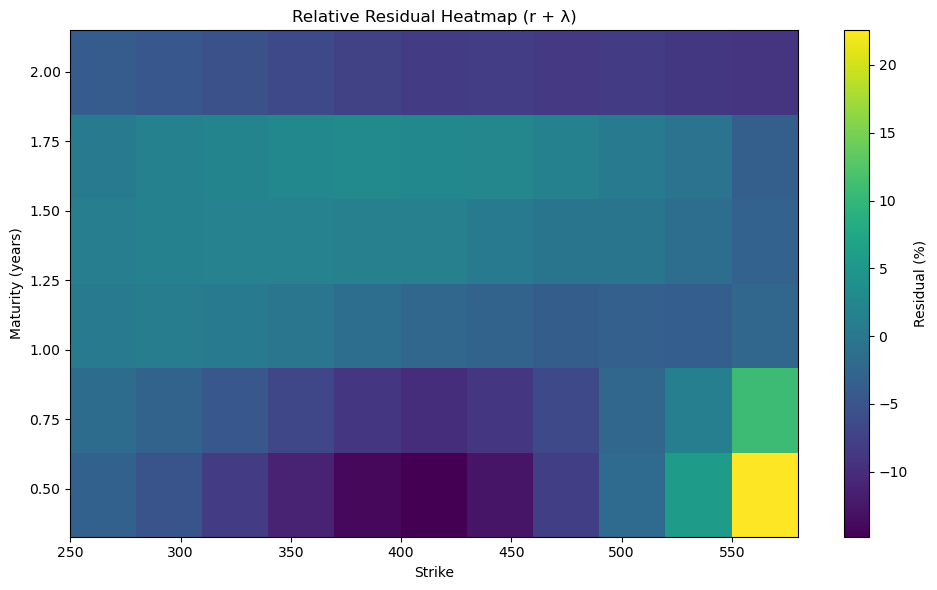

In [15]:
# === ANALISI RESIDUI: HESTON (r_eff = r + λ da JSON) ===
import numpy as np, pandas as pd, json, os

OUT_PREFIX = "mstr_panel"
PARAMS_FILE = f"{OUT_PREFIX}_heston_params_default.json"  # creato dalla calibrazione λ libero

# --- prerequisiti runtime ---
assert 'heston_price_rec' in globals(), "Definisci heston_price_rec prima di eseguire."
assert 'volSurfaceFilteredLong' in globals(), "Manca volSurfaceFilteredLong in memoria."
assert os.path.exists(PARAMS_FILE), f"{PARAMS_FILE} non trovato"

# --- carica parametri stimati (λ incluso) ---
with open(PARAMS_FILE, "r", encoding="utf-8") as f:
    p = json.load(f)

S0             = float(p["S0"])
v0             = float(p["v0"])
kappaQ         = float(p["kappaQ"])
thetaQ         = float(p["thetaQ"])
xi             = float(p["xi"])
rho            = float(p["rho"])
LAMBDA_DEFAULT = float(p.get("lambda", p.get("lambda_default")))

# --- prepara dataset e r_eff ---
need = {"maturity","strike","price","rate"}
assert need.issubset(volSurfaceFilteredLong.columns), "volSurfaceFilteredLong incompleto"
df = (volSurfaceFilteredLong.loc[:, list(need)]
      .dropna()
      .astype({"maturity":float,"strike":float,"price":float,"rate":float})
      .reset_index(drop=True))
df["rate_eff"] = df["rate"] + LAMBDA_DEFAULT

# --- prezzi Heston su r_eff ---
K_arr = df["strike"].to_numpy(float)
T_arr = df["maturity"].to_numpy(float)
r_arr = df["rate_eff"].to_numpy(float)

Ph = np.empty_like(K_arr, dtype=float)
for i in range(K_arr.size):
    Ph[i] = heston_price_rec(S0, float(K_arr[i]), v0, kappaQ, thetaQ, xi, rho,
                             float(T_arr[i]), float(r_arr[i]))
df["heston_price"] = Ph

# --- residui assoluti e relativi ---
EPS = 1e-8
P   = df["price"].to_numpy(float)
df["abs_resid"] = P - df["heston_price"]
df["rel_resid"] = df["abs_resid"] / np.maximum(P, EPS)
df["abs_err"]   = np.abs(df["abs_resid"])
df["rel_err"]   = np.abs(df["rel_resid"])

# --- metriche globali ---
mae      = float(df["abs_err"].mean())
rmse     = float(np.sqrt((df["abs_resid"]**2).mean()))
bias     = float(df["abs_resid"].mean())
rel_mae  = float(df["rel_err"].mean())
rel_rmse = float(np.sqrt((df["rel_resid"]**2).mean()))
rel_bias = float(df["rel_resid"].mean())

print(f"[GLOBAL]  MAE={mae:.6f}  RMSE={rmse:.6f}  Bias={bias:.6f}  |  RelMAE={100*rel_mae:.3f}%  RelRMSE={100*rel_rmse:.3f}%  RelBias={100*rel_bias:.3f}%")
print(f"λ usato: {LAMBDA_DEFAULT:.6f}")

# --- riepilogo per maturità (include RelRMSE) ---
grpT = df.groupby("maturity", sort=True)
err_T = (pd.DataFrame({
            "rel_err_inf": grpT["rel_err"].max(),
            "rel_err_mean": grpT["rel_err"].mean(),
            "rel_rmse": grpT["rel_resid"].apply(lambda x: float(np.sqrt(np.mean(np.square(x))))),
            "bias": grpT["abs_resid"].mean(),
            "n_points": grpT.size()
        })
        .reset_index()
        .sort_values("maturity"))
err_T["rel_err_inf_pct"]  = 100.0 * err_T["rel_err_inf"]
err_T["rel_err_mean_pct"] = 100.0 * err_T["rel_err_mean"]
err_T["rel_rmse_pct"]     = 100.0 * err_T["rel_rmse"]
print("\n[BY MATURITY]\n", err_T)

# --- riepilogo per strike (include RelRMSE) ---
grpK = df.groupby("strike", sort=True)
err_K = (pd.DataFrame({
            "rel_err_inf": grpK["rel_err"].max(),
            "rel_err_mean": grpK["rel_err"].mean(),
            "rel_rmse": grpK["rel_resid"].apply(lambda x: float(np.sqrt(np.mean(np.square(x))))),
            "bias": grpK["abs_resid"].mean(),
            "n_points": grpK.size()
        })
        .reset_index()
        .sort_values("strike"))
err_K["rel_err_inf_pct"]  = 100.0 * err_K["rel_err_inf"]
err_K["rel_err_mean_pct"] = 100.0 * err_K["rel_err_mean"]
err_K["rel_rmse_pct"]     = 100.0 * err_K["rel_rmse"]
print("\n[BY STRIKE]\n", err_K.head(20))

# --- matrici pivot per heatmap ---
resid_surface_abs = (df.pivot_table(index="maturity", columns="strike", values="abs_resid", aggfunc="mean")
                      .sort_index().sort_index(axis=1))
resid_surface_rel = (df.pivot_table(index="maturity", columns="strike", values="rel_resid", aggfunc="mean")
                      .sort_index().sort_index(axis=1))

# --- salvataggi ---
df.to_csv(f"{OUT_PREFIX}_residuals_default_full.csv", index=False)
err_T.to_csv(f"{OUT_PREFIX}_residuals_default_by_maturity.csv", index=False)
err_K.to_csv(f"{OUT_PREFIX}_residuals_default_by_strike.csv", index=False)

summary = {
    "lambda_default": float(LAMBDA_DEFAULT),
    "global": {
        "MAE": mae, "RMSE": rmse, "Bias": bias,
        "RelMAE_pct": 100*rel_mae, "RelRMSE_pct": 100*rel_rmse, "RelBias_pct": 100*rel_bias
    },
    "counts": int(len(df)),
    "unique_maturities": int(df["maturity"].nunique()),
    "unique_strikes": int(df["strike"].nunique())
}
with open(f"{OUT_PREFIX}_residuals_default_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print(f"\n[SAVE]\n  {OUT_PREFIX}_residuals_default_full.csv\n  {OUT_PREFIX}_residuals_default_by_maturity.csv\n  {OUT_PREFIX}_residuals_default_by_strike.csv\n  {OUT_PREFIX}_residuals_default_summary.json")

# --- heatmap opzionale ---
try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    plt.imshow(100*np.array(resid_surface_rel), aspect="auto", origin="lower",
               extent=[resid_surface_rel.columns.min(), resid_surface_rel.columns.max(),
                       resid_surface_rel.index.min(), resid_surface_rel.index.max()])
    plt.colorbar(label="Residual (%)")
    plt.xlabel("Strike"); plt.ylabel("Maturity (years)")
    plt.title("Relative Residual Heatmap (r + λ)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("[PLOT] skipped:", e)
